# Recommendation System

## Collaborative-Filtering

In [12]:
import math
import heapq
import pandas as pd
import numpy as np

from random import shuffle
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Multiply, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2

import pickle

### Functions

In [10]:
def get_negatives(uids, iids, items, df_test, num_neg = 13):
    """
    Returns a pandas dataframe of num_neg negative interactions
    based for each (user, item) pair in df_test.
    
    Args:
        uids (list): all user ids
        iids (list): all item ids
        items (list): all unique items within historical data
        df_test (dataframe): test dataset from train_test_split
        num_neg (int): number of negative interactions
        
    Returns:
        df_neg (dataframe): dataframe with 15 negative items 
            for each (user, item) pair in df_test.
    """

    negativeList = []
    test_u = df_test['user_id'].values.tolist()
    test_i = df_test['vendor_id'].values.tolist()

    test_ratings = list(zip(test_u, test_i))
    zipped = set(zip(uids, iids))

    for (u, i) in test_ratings:
        negatives = []
        negatives.append((u, i))
        for t in range(num_neg):
            j = np.random.randint(len(items)) # Get random item id.
            while (u, j) in zipped: # Check if there is an interaction
                j = np.random.randint(len(items)) # If yes, generate a new item id
            negatives.append(j) # Once a negative interaction is found we add it.
        negativeList.append(negatives)

    df_neg = pd.DataFrame(negativeList)

    return df_neg


def mask_first(x):
    """
    Return a list of 0 for the first item and 1 for all others
    """

    result = np.ones_like(x)
    result[0] = 0
    
    return result
   

def train_test_split(df):
    """
    Split dataset into training and test dataset.
    The training set is made of all of our data except holdout items, while
    the test set is only holdout items for each users.
    
    Args:
        df (dataframe): original dataset.
        
    Returns:
        df_train (dataframe): original dataset except holdout items for each users
        df_test (dataframe): only holdout items for each users.
    """

    # Create two copies of our dataframe that we can modify
    df_test = df.copy(deep = True)
    df_train = df.copy(deep = True)

    # Group by user_id and select only the first item for
    # each user (our holdout).
    df_test = df_test.groupby(['user_id']).first()
    df_test['user_id'] = df_test.index
    df_test = df_test[['user_id', 'vendor_id', 'rating']]

    # Remove the same items for our test set in our training set.
    mask = df.groupby(['user_id'])['user_id'].transform(mask_first).astype(bool)
    df_train = df.loc[mask]

    return df_train, df_test


def load_dataset():
    """
    Load data from cloud database.

    Returns:
        df_medpar (dataframe): original dataset for media partner.
        df_rental (dataframe): original dataset for rental.
        df_sponsor (dataframe): original dataset for sponsorship.
    """

    df_medpar = pd.read_csv('medpar_reviews.csv')
    df_medpar = df_medpar.rename(columns = {'mp_id': 'vendor_id'})
    
    df_rental = pd.read_csv('rentals_reviews.csv')
    df_rental = df_rental.rename(columns = {'rt_id': 'vendor_id'})
    
    df_sponsor = pd.read_csv('sponsorship_reviews.csv')
    df_sponsor = df_sponsor.rename(columns = {'sp_id': 'vendor_id'})

    return df_medpar, df_rental, df_sponsor


def transform_dataset(df_medpar, df_rental, df_sponsor):
    """
    Transform dataset into a list of users and items as per stated here:
    https://medium.com/@victorkohler/collaborative-filtering-using-deep-neural-networks-in-tensorflow-96e5d41a39a1
    
    Args:
        df_medpar (dataframe): original dataset for media partner.
        df_rental (dataframe): original dataset for rental.
        df_sponsor (dataframe): original dataset for sponsorship.

    Returns:
        uids (list): all user ids.
        iids (list): all item ids.
        df_train (dataframe): original dataset except holdout items for each users.
        df_test (dataframe): only holdout items for each users.
        df_neg (dataframe): dataframe with 15 negative items
            for each (user, item) pair in df_test.
        users (list): all unique users.
        items (list): all unique items.
        label_encoder_user (LabelEncoder): encoder for user_id.
        label_encoder_item (LabelEncoder): encoder for item_id.
    """

    # Union the results
    df = pd.concat([df_medpar, df_rental, df_sponsor], 
                    ignore_index = True)
    df = df[['user_id', 'vendor_id', 'rating']]

    df = df.loc[df['rating'] >= 4]

    # Encode user_id and vendor_id
    label_encoder_user = LabelEncoder()
    label_encoder_item = LabelEncoder() 

    df['user_id'] = label_encoder_user.fit_transform(df['user_id'])
    df['vendor_id'] = label_encoder_item.fit_transform(df['vendor_id'])

    # Create training and test sets.
    df_train, df_test = train_test_split(df)

    # Create lists of all unique users and artists
    users = list(df['user_id'].unique()) # Label
    items = list(df['vendor_id'].unique()) # Label

    # Get all user ids and item ids.
    uids = df_train['user_id'].tolist() # Label
    iids = df_train['vendor_id'].tolist() # Label

    # Sample negative interactions for each user in our test data
    df_neg = get_negatives(uids, iids, items, df_test) # Label
    
    return uids, iids, df_train, df_test, df_neg, users, items, label_encoder_user, label_encoder_item


def get_train_instances(uids, iids, items, portion = 0.05):
    """
    Samples a number of negative user-item interactions for each
    user-item pair in our testing data.

    Args:
        uids (list): all users' id within the historical data.
        iids (list): all items' id within the historical data.
        items (list): list of all unique items.
        portion (float): portion of items used for training.
     
    Returns:
        user_input (list): A list of all users for each item.
        item_input (list): A list of all items for every user,
            both positive and negative interactions.
        labels (list): A list of all labels. 0 or 1.
    """

    # Number of negative interactions for fitting
    num_neg = int(portion * len(items) // 50) * 50

    # Training instances
    user_input, item_input, labels = [], [], []
    zipped = set(zip(uids, iids))
    
    for (u, i) in zip(uids, iids):
        # Add our positive interaction
        user_input.append(u)
        item_input.append(i)
        labels.append(1)

        # Sample a number of random negative interactions
        for t in range(num_neg):
            j = np.random.randint(len(items))
            while (u, j) in zipped:
                j = np.random.randint(len(items))
            user_input.append(u)
            item_input.append(j)
            labels.append(0)

    return user_input, item_input, labels


def get_hits(k_ranked, holdout):
    """
    Return 1 if the holdout item exists in a given list and 0 if not.
    """

    for item in k_ranked:
        if item == holdout:
            return 1
    return 0


def get_ndcg(ranklist, gtItem):
    """
    NDCG@k is a ranking metric that helps consider 
    both the relevance of items and their positions in the list.
    """

    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0


def predict_ratings_cf(user_id, items, model, label_user, label_item):
    """
    Predict rating score for each user across all items.

    Args:
        user_id (int): current user_id.
        items (list): all unique items within historical data.
        model (h5): recsys tensorflow model.
        label_user (int): label encoder for user.
        label_item (int): label encoder for item.
        
    Returns:
        map_item_score (list): predicted current user rating for each item.
    """

    # Prepare user and item arrays for the model.
    user_id = label_user.transform([user_id])[0] # Label
    predict_user = np.full(len(items), user_id, dtype = 'int32').reshape(-1, 1) # Label
    np_items = np.array(items).reshape(-1, 1)

    # Predict ratings using the model.
    predictions = model.predict([predict_user, np_items]).flatten().tolist()

    # Map predicted score to item id.
    items = label_item.inverse_transform(items) # Original
    map_item_score = dict(zip(items, predictions))

    return map_item_score
    

def eval_rating(idx, test_ratings, test_negatives, K, model, label_user, label_item):
    """
    Generate ratings for the users in our test set and
    check if our holdout item is among the top K item with the highest scores
    and evaluate its position.
    
    Args:
        idx (int): current user_id in label encoding.
        test_ratings (list): test dataset (user, item) pairs.
        test_negatives (list): negative items for each user in test dataset.
        K (int): number of top recommendations.
        label_user (int): label encoder for user.
        label_item (int): label encoder for item.
        
    Returns:
        hitrate (list): A list of 1 if the holdout appeared in our
            top K predicted items. 0 if not.
    """

    # Get the negative interactions for our user.
    items = test_negatives[idx] # Label

    # Get the user idx.
    user_idx = test_ratings[idx][0] # Label
    user_idx = label_user.inverse_transform([user_idx])[0] # Original

    # Get the item idx, i.e., our holdout item.
    holdout = test_ratings[idx][1] # Label

    # Add the holdout to the end of the negative interactions list.
    items.append(holdout) # Label

    # Predict ratings using the model.
    map_item_score = predict_ratings_cf(user_idx, items, model, label_user, label_item) # Original
    items.pop()

    # Get the K highest ranked items as a list.
    k_ranked = heapq.nlargest(K, map_item_score, key = map_item_score.get) # Original
    k_ranked = label_item.transform(k_ranked) # Label

    # Get a list of hit or no hit.
    hitrate = get_hits(k_ranked, holdout)
    ndcg = get_ndcg(k_ranked, holdout)

    return (hitrate, ndcg)


def evaluate(model, df_test, df_neg, label_user, label_item, K = 10):
    """
    Calculate the top@K hit ratio for our recommendations.
    
    Args:
        df_neg (dataframe): dataframe containing our holdout items
            and K randomly sampled negative interactions for each
            (user, item) holdout pair.
        label_user (int): label encoder for user.
        label_item (int): label encoder for item.
        K (int): number of recommended items.
            
    Returns:
        hits (list): list of "hits". 1 if the holdout was present in 
            the K highest ranked predictions. 0 if not. 
    """

    hitrates = []
    ndcgs = []

    test_u = df_test['user_id'].values.tolist() # Label
    test_i = df_test['vendor_id'].values.tolist() # Label

    test_ratings = list(zip(test_u, test_i))

    df_neg = df_neg.drop(df_neg.columns[0], axis = 1)
    test_negatives = df_neg.values.tolist()

    for user_id in test_u: # Label
        # For each idx, call eval_one_rating
        (hitrate, ndcg) = eval_rating(user_id, test_ratings, test_negatives, K, model, label_user, label_item)
        hitrates.append(hitrate)
        ndcgs.append(ndcg)

    return (hitrates, ndcgs)


def get_top_k_items(dct, k = 10):
    """
    Get the top k items for the recommendations
    
    Args:
        dct (dict): dictionary of "hits" for each item
        k (int): number of recommended items
            
    Returns:
        average_ratings (list): list of average ratings for each item
        recommendation_items (list): list of recommended items
    """

    # Use nlargest to get the top n key-value pairs based on values.
    top_k_items = heapq.nlargest(k, dct.items(), key = lambda item: item[1])

    # Calculate avg rating for each item.
    average_ratings = [item[1] for item in top_k_items]
    recommendation_items = [item[0] for item in top_k_items]

    # Convert all items to strings.
    average_ratings = [str(item) for item in average_ratings]
    recommendation_items = [str(item) for item in recommendation_items]

    return average_ratings, recommendation_items

### Implementation

In [13]:
# Load dataset
df_medpar, df_rental, df_sponsor = load_dataset()
uids, iids, df_train, df_test, df_neg, users, items, label_encoder_user, label_encoder_item = transform_dataset(df_medpar, df_rental, df_sponsor)

# HYPERPARAMS
epochs = 10
batch_size = 1024

In [14]:
# TENSORFLOW GRAPH
# Using the functional API

# HYPERPARAMS
latent_features = 20
learning_rate = 0.005

# TENSORFLOW GRAPH
# Using the functional API

# Define input layers for user, item, and label.
user_input = Input(shape = (1,), dtype = tf.int32, name = 'user')
item_input = Input(shape = (1,), dtype = tf.int32, name = 'item')
label_input = Input(shape = (1,), dtype = tf.int32, name = 'label')

# User embedding for MLP
mlp_user_embedding = Embedding(input_dim = len(users), 
                                output_dim = latent_features,
                                embeddings_initializer = 'random_normal',
                                embeddings_regularizer = L1(0.01),
                                input_length = 1, 
                                name = 'mlp_user_embedding')(user_input)

# Item embedding for MLP
mlp_item_embedding = Embedding(input_dim = len(items), 
                               output_dim = latent_features,
                               embeddings_initializer = 'random_normal',
                               embeddings_regularizer = L1(0.01),
                               input_length = 1, 
                               name = 'mlp_item_embedding')(item_input)

# User embedding for GMF
gmf_user_embedding = Embedding(input_dim = len(users), 
                               output_dim = latent_features,
                               embeddings_initializer = 'random_normal',
                               embeddings_regularizer = L1(0.01),
                               input_length = 1, 
                               name = 'gmf_user_embedding')(user_input)

# Item embedding for GMF
gmf_item_embedding = Embedding(input_dim = len(items), 
                               output_dim = latent_features,
                               embeddings_initializer = 'random_normal',
                               embeddings_regularizer = L1(0.01),
                               input_length = 1, 
                               name = 'gmf_item_embedding')(item_input)

# GMF layers
gmf_user_flat = Flatten()(gmf_user_embedding)
gmf_item_flat = Flatten()(gmf_item_embedding)
gmf_matrix = Multiply()([gmf_user_flat, gmf_item_flat])

# MLP layers
mlp_user_flat = Flatten()(mlp_user_embedding)
mlp_item_flat = Flatten()(mlp_item_embedding)
mlp_concat = Concatenate()([mlp_user_flat, mlp_item_flat])

mlp_dropout = Dropout(0.1)(mlp_concat)

mlp_layer_1 = Dense(64, 
                    activation = 'relu', 
                    name = 'mlp_layer1')(mlp_dropout)
mlp_batch_norm1 = BatchNormalization(name = 'mlp_batch_norm1')(mlp_layer_1)
mlp_dropout1 = Dropout(0.1, 
                    name = 'mlp_dropout1')(mlp_batch_norm1)

mlp_layer_2 = Dense(32, 
                    activation = 'relu', 
                    name = 'mlp_layer2')(mlp_dropout1)
mlp_batch_norm2 = BatchNormalization(name = 'mlp_batch_norm2')(mlp_layer_2)
mlp_dropout2 = Dropout(0.1, 
                    name = 'mlp_dropout2')(mlp_batch_norm2)

mlp_layer_3 = Dense(16, 
                    activation = 'relu', 
                    kernel_regularizer = L2(0.01),
                    name = 'mlp_layer3')(mlp_dropout2)
mlp_layer_4 = Dense(8, 
                    activation = 'relu', 
                    activity_regularizer = L2(0.01),
                    name = 'mlp_layer4')(mlp_layer_3)

# Merge the two networks
merged_vector = Concatenate()([gmf_matrix, mlp_layer_4])

# Output layer
output_layer = Dense(1, 
                    activation = 'sigmoid',
                    kernel_initializer = 'lecun_uniform',
                    name = 'output_layer')(merged_vector)

# Define the model
model = Model(inputs = [user_input, item_input], outputs = output_layer)

# Compile the model with binary cross entropy loss and Adam optimizer
optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Print the model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 mlp_user_embedding (Embedd  (None, 1, 20)                400       ['user[0][0]']                
 ing)                                                                                             
                                                                                                  
 mlp_item_embedding (Embedd  (None, 1, 20)                44140     ['item[0][0]']          

In [16]:
for epoch in range(epochs):
    # Get our training input.
    user_input, item_input, labels = get_train_instances(uids, iids, items)

    # Training        
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size = batch_size, 
                     verbose = 0, 
                     shuffle = True)

    # Evaluation
    (hitrates, ndcgs) = evaluate(model, df_test, df_neg, label_encoder_user, label_encoder_item)
    hitrates_avg, ndcgs_avg, loss = np.array(hitrates).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
    print(hitrates_avg)

1/1 [==============================] - 0s 42ms/step
0.8
1/1 [==============================] - 0s 38ms/step
0.7
1/1 [==============================] - 0s 73ms/step
0.8
1/1 [==============================] - 0s 48ms/step
0.7
1/1 [==============================] - 0s 43ms/step
0.7
1/1 [==============================] - 0s 102ms/step
0.75
1/1 [==============================] - 0s 79ms/step
0.6
1/1 [==============================] - 0s 49ms/step
0.75
1/1 [==============================] - 0s 47ms/step
0.6
1/1 [==============================] - 0s 46ms/step
0.65


### Save Model

In [35]:
model.save('collaborative-filtering.h5')

c:\users\c640\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Content-Based Filtering

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c640\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Data (Content = Business's Description)

In [21]:
df = pd.read_csv("sponsors.csv")
df

,name,category,sub-category,about,metadata
0,Asus Indonesia,Sponsor,Technology Hardware,ASUS is passionate about technology and driven...,Sponsor Technology Hardware ASUS is passionate...
1,Hydro Coco,Sponsor,Food & Beverage,Tentang Hydro Coco\nHydro Coco terbuat dari ai...,Sponsor Food & Beverage Tentang Hydro Coco\nHy...
2,Nutrijell,Sponsor,Food & Beverage,Nutrijell is a leading agar-agar brand in Indo...,Sponsor Food & Beverage Nutrijell is a leading...
3,Zalora Indonesia,Sponsor,E-Commerce,"Zalora Indonesia, the largest online fashion r...","Sponsor E-Commerce Zalora Indonesia, the large..."
4,Marina,Sponsor,Personal & Beauty,Marina Natural is a leading Indonesian cosmeti...,Sponsor Personal & Beauty Marina Natural is a ...
...,...,...,...,...,...
857,photobooth wedding murah jabodetabek,Equipment Rental,Photobooth,photobooth wedding murah jabodetabek,Equipment Rental Photobooth photobooth wedding...
858,photo booth ulang tahun murah,Equipment Rental,Photobooth,photo booth ulang tahun murah,Equipment Rental Photobooth photo booth ulang ...
859,MobileTrans - Wa Transfer dan Line Transfer Or...,Equipment Rental,Photobooth,MobileTrans - Wa Transfer dan Line Transfer Or...,Equipment Rental Photobooth MobileTrans - Wa T...
860,SEWA WIFI JEPANG | JAPAN WIFI | SEWA JAPAN WIFI,Equipment Rental,Photobooth,SEWA WIFI JEPANG | JAPAN WIFI | SEWA JAPAN WIFI,Equipment Rental Photobooth SEWA WIFI JEPANG |...


### Encode All About to a Bank

In [22]:
bow = CountVectorizer(stop_words="english", min_df=1, tokenizer=word_tokenize)
bank = bow.fit_transform(df.metadata)

c:\users\c640\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Steps

#### 1: Encode What User Click

In [23]:
idx = 66

content = df.loc[idx, "metadata"]
content

'Sponsor Personal & Beauty Makeover is an Indonesian cosmetics brand offering a comprehensive range of makeup and skincare products. With a focus on providing high-quality and on-trend beauty items, Makeover has gained popularity among consumers seeking both traditional and modern beauty solutions.'

In [24]:
code = bow.transform([content])
code.toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### 2: Document Search

In [25]:
dist = cosine_distances(code, bank)
dist

array([[0.75851277, 0.88859377, 0.70621517, 0.78445245, 0.68715064,
        0.69543382, 0.74952253, 0.79675608, 0.70670577, 0.73547997,
        0.70997345, 0.78054973, 0.7451983 , 0.71042975, 0.73489413,
        0.75828058, 0.76216464, 0.78841818, 0.76566679, 0.72397378,
        0.75241797, 0.74215602, 0.68813284, 0.76901369, 0.77016514,
        0.70610923, 0.7498918 , 0.57269639, 0.72998212, 0.8059039 ,
        0.83697217, 0.83295903, 0.77571935, 0.75483361, 0.77980999,
        0.67600313, 0.81229654, 0.75060813, 0.7628821 , 0.7475866 ,
        0.6448576 , 0.67463742, 0.66238815, 0.79566466, 0.73660671,
        0.73917973, 0.79826335, 0.78510261, 0.79903003, 0.73752467,
        0.81442313, 0.75914517, 0.73057466, 0.7606225 , 0.77169417,
        0.71067834, 0.42616442, 0.79380348, 0.7634779 , 0.76053963,
        0.42758022, 0.73959275, 0.63968168, 0.7432237 , 0.79193741,
        0.74316525, 0.        , 0.83354992, 0.80097892, 0.76671526,
        0.76194412, 0.65060117, 0.76671526, 0.61

In [26]:
rec_idx = dist.argsort()[0, 1:11]
rec_idx

array([56, 60, 80, 83, 27, 73, 62, 40, 71, 42], dtype=int64)

#### 3: Recommend

In [ ]:
df.loc[rec_idx]

### MLE: Sum Them All Up

In [43]:
class RecommenderSystem:
    def __init__(self, data, content_col):
        self.df = pd.read_csv(data)
        self.content_col = content_col
        self.encoder = None
        self.model = None

    def preprocess_data(self):
        X_train, X_val, y_train, y_val = train_test_split(
            self.df['metadata'], self.df['category'], test_size=0.2, random_state=42
        )

        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_val_encoded = label_encoder.transform(y_val)

        return X_train, X_val, y_train_encoded, y_val_encoded

    def train_model(self, X_train, y_train, X_val, y_val, epochs=10):
        self.encoder = CountVectorizer(stop_words="english", tokenizer=word_tokenize)
        X_train_encoded = self.encoder.fit_transform(X_train).toarray()
        X_val_encoded = self.encoder.transform(X_val).toarray()

        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train_encoded.shape[1],)),
            Dense(64, activation='relu'),
            Dense(len(np.unique(y_train)), activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_encoded, y_train, epochs=epochs, validation_data=(X_val_encoded, y_val), verbose=1)

        # Extract final training and validation accuracy
        final_train_accuracy = history.history['accuracy'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]

        print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
        print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

        # Save the trained model
        model.save("content-based-filtering.h5")

        return model, history

    def plot_accuracy(self, history):
        # Plot training and validation accuracy
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def fit(self):
        self.encoder = CountVectorizer(stop_words="english", tokenizer=word_tokenize)
        self.bank = self.encoder.fit_transform(self.df[self.content_col])

    def recommend(self, idx, topk=10):
        content = df.loc[idx, self.content_col]
        code = self.encoder.transform([content])
        dist = cosine_distances(code, self.bank)
        rec_idx = dist.argsort()[0, 1:(topk+1)]
        return self.df.loc[rec_idx]

    def run(self):
        X_train, X_val, y_train, y_val = self.preprocess_data()
        self.model, history = self.train_model(X_train, y_train, X_val, y_val, epochs=10)
        self.plot_accuracy(history)

c:\users\c640\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10
22/22 [==============================] - 1s 21ms/step - loss: 0.3270 - accuracy: 0.9637 - val_loss: 0.0561 - val_accuracy: 1.0000
Epoch 2/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0168 - accuracy: 0.9985 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 3/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/10
22/22 [==============================] - 0s 14ms/step - loss: 8.7752e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
22/22 [==============================] - 0s 18ms/step - loss: 6.4889e-04 - accuracy: 1.0000 - val_loss: 9.7522e-04 - val_accuracy: 1.0000
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 5.3736e-04 - accuracy: 1.0000 - val_loss: 7.7193e-04 - val_accuracy: 

c:\users\c640\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


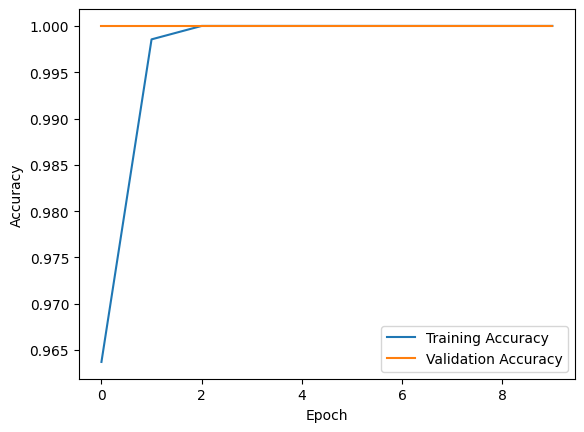

In [44]:
recsys = RecommenderSystem("sponsors.csv", content_col="metadata")
recsys.run()

In [45]:
recsys.fit()
recsys.recommend(66)

,name,category,sub-category,about,metadata
56,Mustika Ratu,Sponsor,Personal & Beauty,Mustika Ratu is a well-known Indonesian cosmet...,Sponsor Personal & Beauty Mustika Ratu is a we...
60,Holika-holika,Sponsor,Personal & Beauty,Holika-holika is a South Korean cosmetics bran...,Sponsor Personal & Beauty Holika-holika is a S...
80,Wardah,Sponsor,Personal & Beauty,Wardah is an Indonesian cosmetics and skincare...,Sponsor Personal & Beauty Wardah is an Indones...
83,The Body Shop,Sponsor,Personal & Beauty,The Body Shop is a global beauty and cosmetics...,Sponsor Personal & Beauty The Body Shop is a g...
27,Paragon,Sponsor,Personal & Beauty,Paragon Technology and Innovation is an Indone...,Sponsor Personal & Beauty Paragon Technology a...
73,Nivea,Sponsor,Personal & Beauty,Nivea is a global brand that primarily focuses...,Sponsor Personal & Beauty Nivea is a global br...
62,Damn I Love Indonesia,Sponsor,Textiles & Apparel,Damn I Love Indonesia (DILo) is a lifestyle br...,Sponsor Textiles & Apparel Damn I Love Indones...
40,Head & Shoulders,Sponsor,Personal & Beauty,Head & Shoulders is a well-known brand of anti...,Sponsor Personal & Beauty Head & Shoulders is ...
71,Bukalapak,Sponsor,E-Commerce,Bukalapak is an Indonesian online marketplace ...,Sponsor E-Commerce Bukalapak is an Indonesian ...
42,Alfamart,Sponsor,Distribution & Retail,Alfamart is a leading Indonesian convenience s...,Sponsor Distribution & Retail Alfamart is a le...


### Save Model

Model is already saved by the time we this the following code:
`
recsys.run()
`

# Natural Language Processing

## Sentiment Analysis

#### 1. Import modules and dataset

In [16]:
# import the dataset
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Flatten, Bidirectional,GlobalMaxPooling1D,Conv1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import joblib
import numpy as np


# Load the data
file_path = 'PRDECT-ID Dataset.csv'
data = pd.read_csv(file_path)

data


,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy
...,...,...,...,...,...,...,...,...,...,...,...
5395,Household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,Jakarta Pusat,35000,4.9,1431,562,5,"Harga bersaing, barang sesuai pesanan. Saya na...",Positive,Love
5396,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Beli ini krn Anak & Istri mau liburan di Jakar...,Positive,Love
5397,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,"pengemasan barang baik, kondisi barang jg utuh...",Positive,Happy
5398,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Mungil tapi bekerja dng baik. Dan murahh terja...,Positive,Happy


#### 2. Data Preprocessing

In [12]:
# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

# Clean the reviews
data['Cleaned_Review'] = data['Customer Review'].apply(clean_text)

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Cleaned_Review'])

tokenizer_json = tokenizer.to_json()
with open("nlp_tokenizer.json", "w") as json_file:
    json_file.write(tokenizer_json)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['Cleaned_Review'])

# Pad the sequences to have uniform length
max_length = 1000
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Encode the target variable
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['Emotion'])
joblib.dump(label_encoder, 'nlp_label_encoder.joblib')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)


#### 3. Data Modeling

In [15]:
vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/10
68/68 [==============================] - 31s 448ms/step - loss: 1.4179 - accuracy: 0.3877 - val_loss: 1.1184 - val_accuracy: 0.5176
Epoch 2/10
68/68 [==============================] - 30s 437ms/step - loss: 0.9132 - accuracy: 0.5961 - val_loss: 0.9089 - val_accuracy: 0.5944
Epoch 3/10
68/68 [==============================] - 33s 478ms/step - loss: 0.6013 - accuracy: 0.7711 - val_loss: 0.9275 - val_accuracy: 0.6000
Epoch 4/10
68/68 [==============================] - 32s 478ms/step - loss: 0.3308 - accuracy: 0.9000 - val_loss: 0.9991 - val_accuracy: 0.6157
Epoch 5/10
68/68 [==============================] - 34s 496ms/step - loss: 0.1495 - accuracy: 0.9657 - val_loss: 1.1655 - val_accuracy: 0.6176
Epoch 6/10
68/68 [==============================] - 29s 434ms/step - loss: 0.0879 - accuracy: 0.9780 - val_loss: 1.3228 - val_accuracy: 0.6083
Epoch 7/10
68/68 [==============================] - 31s 449ms/step - loss: 0.0617 - accuracy: 0.9850 - val_loss: 1.3918 - val_accuracy: 0.6028

#### 4. Predicting emotions

In [17]:

# Example Indonesian sentences
sentences = ["Produknya keren.",
             "Ga sesuai ekspektasi.",
             "Jangan beli di sini, penjual ga ramah.",
             "Barangnya jelek."]

# Preprocess the sentences (cleaning, tokenizing, and padding)
cleaned_sentences = [clean_text(sentence) for sentence in sentences] 
encoded_sentences = tokenizer.texts_to_sequences(cleaned_sentences)
padded_sentences = pad_sequences(encoded_sentences, maxlen=max_length, padding='post')

# Predict using the model
predictions = model.predict(padded_sentences)
predicted_emotions = [label_encoder.classes_[np.argmax(prediction)] for prediction in predictions]

# Display predictions
for sentence, emotion in zip(sentences, predicted_emotions):
    print(f"Sentence: '{sentence}' - Predicted Emotion: {emotion}")


1/1 [==============================] - 0s 126ms/step
Sentence: 'Produknya keren.' - Predicted Emotion: Love
Sentence: 'Ga sesuai ekspektasi.' - Predicted Emotion: Sadness
Sentence: 'Jangan beli di sini, penjual ga ramah.' - Predicted Emotion: Fear
Sentence: 'Barangnya jelek.' - Predicted Emotion: Anger


### Summarize

In [19]:
import pandas as pd
import re
import joblib
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

class SentimentAnalysis:
    def __init__(self, 
                 data_path:str,
                 sentences_col:str,
                 label_col:str,
                 max_length:int=1000,
                 padding:str='post'):
        """
            Initialize data and properties
        """
        """
            INPUT
            data_path: where the data is located
            sentences_col: column name in which the full sentences to be trained
            label_col: column name in which the label of the corresponding sentence to be trained
            max_length: number maximum length of a sequence 
            padding: technique to ensure that all sequences in a dataset have the same length

        """
        self.data = pd.read_csv(data_path)
        self.sentences_col = self.data[sentences_col]
        self.label_col = self.data[label_col]
        self.max_length = max_length
        self.padding = padding

    def clean_text(self, text):
        """
            To perform several text cleaning operations
        """
        """ 
            INPUT
            text: the input sentence to be cleaned
        """
        """
            OUTPUT
            preprocessed text with lowercase characters, non-alphanumeric characters, non-whitespace characters,
            and non-numeric characters.
        """
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        return text

    def initialize_tokenizer(self,
                             save_tokenizer:str=None):
        """
            Fit the tokenizer for the text and save it
        """
        """ 
            INPUT
            save_tokenizer: name of the file in which the tokenizer used in this model. 
            If not None, the tokenizer will be saved in json format.
        """
        self.data['cleaned_col'] = self.sentences_col.apply(self.clean_text)
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(self.data['cleaned_col'])
        self.vocab_size = len(self.tokenizer.word_index) + 1

        # Save tokenizer to JSON
        if save_tokenizer is not None:
            tokenizer_json = self.tokenizer.to_json()
            with open(f"{save_tokenizer}", "w") as json_file:
                json_file.write(tokenizer_json)        

    def encode_labels(self, 
                      save_encoder:str=None):
        """
            Fit the label encoder for the label and save it
        """
        """ 
            INPUT
            save_encoder: name of the file in which the label encoder used in this model. 
            If not None, the label encoder will be saved in joblib format.
        """
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.label_col)
        if save_encoder is not None:
            joblib.dump(self.label_encoder, f'{save_encoder}')

    def preprocess_data(self):
        """
            Using tokenizer and label encoder, perform the data preprocessing and data splotting
        """
        self.sequences = self.tokenizer.texts_to_sequences(self.data['cleaned_col'])
        self.padded_sequences = pad_sequences(self.sequences, maxlen=self.max_length, padding=self.padding)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.padded_sequences, 
            self.label_encoder.transform(self.data['Emotion']),
            test_size=0.2, random_state=42
        )

    def create_model(self):
        """
            Create the model architecture and compiler using Tensorflow
        """
        self.model = Sequential()
        self.model.add(Embedding(self.vocab_size, 128, input_length=self.max_length))
        self.model.add(Conv1D(128, 5, activation='relu'))
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(len(self.label_encoder.classes_), activation='softmax'))

        # Smaller learning rate
        optimizer = Adam(learning_rate=0.001)

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def train_model(self,
                    save_model:str="nlp_emotion_model.h5",
                    save_tokenizer:str='nlp_tokenizer.json',
                    save_encoder:str='nlp_label_encoder.joblib'):
        """
            Using Tensorflow, train the data to establish the model
        """
        """ 
            INPUT
            save_model: path where the model will be saved (None if not saving the model)
            save_tokenizer: path where the tokenizer will be saved (None if not saving the model)
            save_encoder: path where the label encoder will be saved (None if not saving the encoder)
        """
        """
            OUTPUT
            model and training history
        """
        self.initialize_tokenizer(save_tokenizer=save_tokenizer)
        self.encode_labels(save_encoder=save_encoder)
        self.preprocess_data()
        self.create_model()
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]

        history = self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=64, validation_data=(self.X_test, self.y_test), callbacks=callbacks)
        if save_model is not None:
            self.model.save(f"{save_model}")

        return self.model, history

    def evaluate_model(self):
        """
            Evaluate the model
        """
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        print(f'Test Loss:{loss}\nTest Accuracy: {accuracy}')


__name__ = "__main__"
if __name__ == "__main__":
    file_path = 'PRDECT-ID Dataset.csv'

    SA = SentimentAnalysis(data_path=file_path,
                           sentences_col='Customer Review',
                           label_col='Emotion',)
    model,history = SA.train_model()
    SA.evaluate_model()
    print(model)


Epoch 1/10
68/68 [==============================] - 30s 438ms/step - loss: 1.4337 - accuracy: 0.3935 - val_loss: 1.1597 - val_accuracy: 0.5157
Epoch 2/10
68/68 [==============================] - 30s 442ms/step - loss: 0.9540 - accuracy: 0.5748 - val_loss: 0.9345 - val_accuracy: 0.5889
Epoch 3/10
68/68 [==============================] - 29s 433ms/step - loss: 0.6592 - accuracy: 0.7544 - val_loss: 0.9062 - val_accuracy: 0.6176
Epoch 4/10
68/68 [==============================] - 29s 428ms/step - loss: 0.3686 - accuracy: 0.8947 - val_loss: 0.9945 - val_accuracy: 0.5981
Epoch 5/10
68/68 [==============================] - 28s 408ms/step - loss: 0.1758 - accuracy: 0.9546 - val_loss: 1.1322 - val_accuracy: 0.5889
Epoch 6/10
68/68 [==============================] - 28s 414ms/step - loss: 0.0922 - accuracy: 0.9755 - val_loss: 1.2590 - val_accuracy: 0.5769
Epoch 7/10
68/68 [==============================] - 28s 411ms/step - loss: 0.0618 - accuracy: 0.9838 - val_loss: 1.3143 - val_accuracy: 0.5824

d:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7\Bangkit\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 2s 56ms/step - loss: 1.5077 - accuracy: 0.5731
Test Loss:1.5076501369476318
Test Accuracy: 0.5731481313705444
<keras.src.engine.sequential.Sequential object at 0x00000235C250B8E0> <keras.src.callbacks.History object at 0x00000235C506A5B0>


In [20]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import joblib

import psycopg2 as pg2
from psycopg2.extras import RealDictCursor
import time
import pandas as pd
class NLP_emotion:
    def __init__(self,
                 model_path,
                 label_encoder_path,
                 tokenizer_path, 
                 set_of_sentences:np.ndarray):
        """
            Initialize data, label encoder, and tokenizer.
        """
        """
            INPUT
            model_path: model's path
            label_encoder_path: label encoder's path 
            tokenizer_path: tokenizer's path 
            set_of_sentences: sentences to be predicted 
        """
        model =  tf.keras.models.load_model(model_path)
        label_encoder = joblib.load(label_encoder_path)
        with open(tokenizer_path, "r", encoding="utf-8") as json_file:
            loaded_tokenizer_json = json_file.read()
        tokenizer = tokenizer_from_json(loaded_tokenizer_json)
        self.model=model
        self.label_encoder=label_encoder
        self.tokenizer=tokenizer
        self.sentences=set_of_sentences

    def clean_text(self,text):
        """
            To perform several text cleaning operations.
        """
        """ 
            INPUT
            text: the input sentence to be cleaned
        """
        """
            OUTPUT
            preprocessed text with lowercase characters, non-alphanumeric characters, non-whitespace characters,
            and non-numeric characters.
        """
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        return text

    def predict_emotions(self):
        """
            To predict the emotions of the sentences using preloaded model, tokenizer, and label encoder.
        """
        """
            OUTPUT
            Dictionary of emotion ("Anger","Fear","Happy","Love","Sadness") and its percentage per sentence.
        """
        max_length = 1000
        cleaned_sentences = [self.clean_text(sentence) for sentence in self.sentences]  
        encoded_sentences = self.tokenizer.texts_to_sequences(cleaned_sentences)
        padded_sentences = pad_sequences(encoded_sentences, maxlen=max_length, padding='post')
        predictions = self.model.predict(padded_sentences)
        return predictions
    
    def percentage_emotions(self):
        """
            To create a comparation ratio of the emotions for all sentences collectively.
        """
        """
            OUTPUT
            Dictionary of portion for all sentences collectively.
        """
        predictions = self.predict_emotions()
        emotion_sums = np.sum(predictions, axis=0)
        emotion_averages = emotion_sums / len(predictions)
        portion_emotion = {label: float(portion) for label, portion in zip(self.label_encoder.classes_, emotion_averages)}
        return portion_emotion
    
sentences = ["Produknya keren.",
             "Ga sesuai ekspektasi.",
             "Jangan beli di sini, penjual ga ramah.",
             "Barangnya jelek."]

nlp_class_coll = NLP_emotion(model_path='nlp_emotion_model.h5',
                        label_encoder_path='nlp_label_encoder.joblib',
                        tokenizer_path='nlp_tokenizer.json',
                        set_of_sentences=sentences)
nlp_class_coll.percentage_emotions()


1/1 [==============================] - 0s 81ms/step


{'Anger': 0.3838447630405426,
 'Fear': 0.029447946697473526,
 'Happy': 0.004473392385989428,
 'Love': 0.2464277744293213,
 'Sadness': 0.3358061611652374}